In [1]:
# Data manipulation
import pandas as pd
import numpy as np
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Metric and model form scikit-learn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import learning_curve
# Boosting model
import catboost as cb
import lightgbm as lgb
import xgboost as xgb
# Tuning optimization
import optuna
import optuna.visualization as vis
# System utilities
import warnings
warnings.filterwarnings("ignore")
import sys
print(sys.executable)


c:\Users\emanu\Analysis-on-Churn-Banking-Modeling-Dataset\.venv\Scripts\python.exe


#### The Dataset

In [2]:
df = pd.read_csv(r"Dataset/Churn_clean.csv") # Data cleaning and feature engineering done in Feature_Engineering.ipynb
df['Imp_Liquidita_Attuale']=df['Imp_Liquidit�_Attuale']
df=df.drop(columns=['Imp_Liquidit�_Attuale'])
df.head()


,Flag_Richiesta_Estinzione_cc,Imp_Valore_del_Cliente,Flag_Apertura_Conto_Online,Flag_Possesso_piu_Conti,Eta,Provincia_Domicilio,Provincia_Residenza,Anno_Apertura_primo_Conto,Professione,Imp_Reddito,...,Flag_Contatto_Call_Center,Flag_variazione_Accredito_Stipendio,Num_Punti_Programma_Loyalty,Imp_Gestito_attuale,Imp_Amministrato_attuale,Flag_Trasferimento_Titoli_Out,Flag_Rifiuto_Carte,Flag_Rifiuto_Prestiti,Flag_Disattivazione_RID,Imp_Liquidita_Attuale
0,no,65.03,0,0,38.0,BO,BO,2004.0,Impiegato,3.0,...,1.0,0.0,NaN,2978.40,2980.92,0,0,0,0,1634.57
1,no,138.88,0,0,45.0,SA,SA,2000.0,Impiegato,4.0,...,1.0,-1.0,325.0,NaN,34916.15,0,0,0,0,11918.26
2,no,546.54,0,0,61.0,VT,VT,2005.0,Altro/Nessuno,4.0,...,1.0,0.0,460.0,NaN,232776.62,1,0,0,0,2671.95
3,no,68.69,0,0,33.0,MI,MI,2010.0,Impiegato,2.0,...,0.0,-1.0,NaN,15013.53,15017.53,0,0,0,0,19211.31
4,no,2417.05,0,0,36.0,MI,MI,2001.0,Quadro,NaN,...,1.0,NaN,3650.0,NaN,NaN,0,0,0,0,1526.38


##### Preprocessing

In [3]:
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1}).astype(int)
XX = pd.get_dummies(X) 

def clean_feature_names(df):
    df.columns = [col.replace(' ', '_').replace('[', '').replace(']', '').replace('<', '') for col in df.columns]
    return df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # Split 4:5, random state to ensure reproducibility

XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False)) #Encoding of the categorical features
X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index] #division in train and test

# apply clean_feature_names
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

X_train, X_test = X_train.align(X_test, join='inner', axis=1) #alignment of train and test columns, to ensure that they have the same lenght

X_train_final = X_train
X_test_final = X_test
y_train_final = y_train
y_test_final = y_test

LightGBM 

In [4]:
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

best_params = {
    "n_estimators": 297,
    "learning_rate": 0.010065762501114987,
    "max_depth": 13,
    "num_leaves": 25,
    "min_child_samples": 28,
    "subsample": 0.9186047768818155,
    "subsample_freq": 5,
    "colsample_bytree": 0.8969786318428297,
    "reg_alpha": 0.9097824682690728,
    "reg_lambda": 0.6075396766185748,
    "max_bin": 289,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight,
    'verbosity': -1
}

best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train_final, y_train_final)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test_final)[:, 1]



In [5]:
import xgboost

# There was a problem with the parameters verbosity, I had to set manually a value in range in main xgboost configuration
xgb.set_config(verbosity=0)
config = xgb.get_config()
assert config['verbosity'] == 0
xgboost.config_context(verbosity=0)
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
xgb_params = {
    'n_estimators': 661,
    'learning_rate': 0.036491004518573594,
    'max_depth': 3,
    'min_child_weight': 4,
    'subsample': 0.6625916610133735,
    'colsample_bytree': 0.864803089169032,
    'gamma': 3.1877873567760657,
    'reg_alpha': 4.436063712881633,
    'reg_lambda': 4.7749277591032975,
    'scale_pos_weight': scale_pos_weight
}

best_xgb_classifier = xgb.XGBClassifier(verbosity=0, **xgb_params)
best_xgb_classifier.fit(X_train_final, y_train_final)
xgb_predictions = best_xgb_classifier.predict_proba(X_test_final)[:, 1]

Catboost

In [6]:
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

catboost_params = {
    'n_estimators': 486,
    'learning_rate': 0.08564115269968339,
    'max_depth': 5,
    'l2_leaf_reg': 5.495063193351241,
    'border_count': 113,
    'grow_policy': 'SymmetricTree',
    'min_data_in_leaf': 8,
    'leaf_estimation_iterations': 9,
    'leaf_estimation_method': 'Gradient',
    'scale_pos_weight': scale_pos_weight,
}

best_catboost_classifier = cb.CatBoostClassifier(**catboost_params)
best_catboost_classifier.fit(X_train_final, y_train_final)
catboost_predictions = best_catboost_classifier.predict_proba(X_test_final)[:, 1]

0:	learn: 0.6638465	total: 172ms	remaining: 1m 23s
1:	learn: 0.6406807	total: 203ms	remaining: 49.2s
2:	learn: 0.6200565	total: 240ms	remaining: 38.6s
3:	learn: 0.6035179	total: 271ms	remaining: 32.7s
4:	learn: 0.5878948	total: 306ms	remaining: 29.4s
5:	learn: 0.5726996	total: 339ms	remaining: 27.1s
6:	learn: 0.5609298	total: 371ms	remaining: 25.4s
7:	learn: 0.5509332	total: 403ms	remaining: 24.1s
8:	learn: 0.5418914	total: 438ms	remaining: 23.2s
9:	learn: 0.5334089	total: 468ms	remaining: 22.3s
10:	learn: 0.5240375	total: 497ms	remaining: 21.5s
11:	learn: 0.5163764	total: 527ms	remaining: 20.8s
12:	learn: 0.5092757	total: 560ms	remaining: 20.4s
13:	learn: 0.5025355	total: 591ms	remaining: 19.9s
14:	learn: 0.4978682	total: 622ms	remaining: 19.5s
15:	learn: 0.4924893	total: 655ms	remaining: 19.3s
16:	learn: 0.4878293	total: 686ms	remaining: 18.9s
17:	learn: 0.4826117	total: 714ms	remaining: 18.6s
18:	learn: 0.4792114	total: 745ms	remaining: 18.3s
19:	learn: 0.4747642	total: 775ms	remain

Ensembling

In [63]:
# Manually set the weight
weight_catboost = 0.6
weight_xgb = 0.3
weight_lgbm = 0.1

In [64]:
catboost_pred = best_catboost_classifier.predict_proba(X_test_final)[:, 1]
xgb_pred = best_xgb_classifier.predict_proba(X_test_final)[:, 1]
lgbm_pred = best_lgb_classifier.predict_proba(X_test_final)[:, 1]

ensemble_predictions = (weight_catboost * catboost_predictions) + (weight_xgb * xgb_predictions) + (weight_lgbm * lgbm_predictions)

In [62]:
results_df = pd.DataFrame({
    'y_test': y_test_final,
    'y_pred_proba': ensemble_predictions

})
#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]
print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)
print("Numero di 'SI: nel nostro test set", count_ones)


Numero di 'SI' nei nostri 10k: 316
Numero di 'SI: nel nostro test set 393


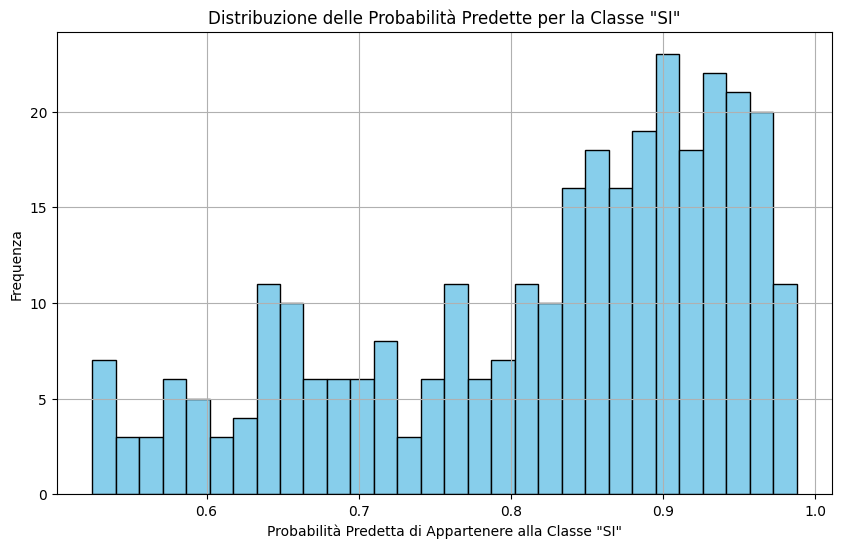

In [47]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

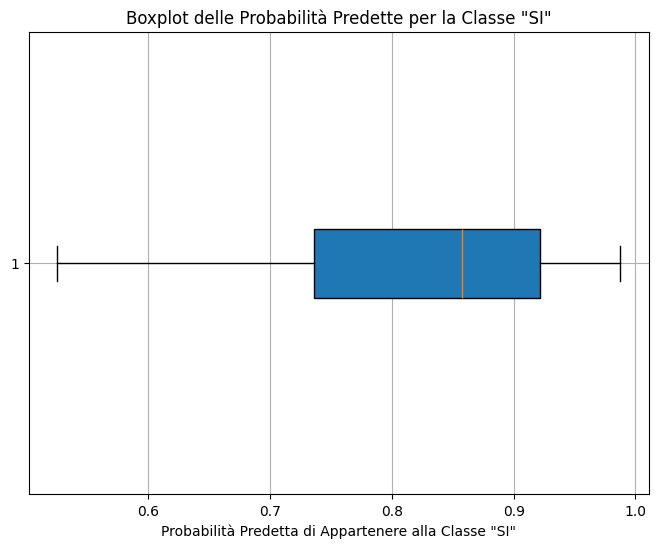

In [48]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

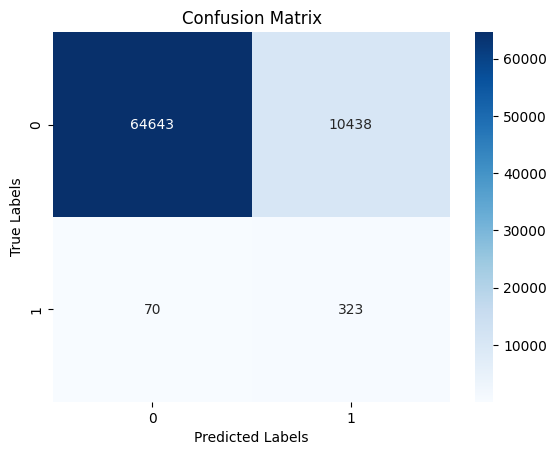

In [59]:
y_pred = (weight_catboost * catboost_pred) + (weight_xgb * xgb_pred) + (weight_lgbm * lgbm_pred)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

cm = confusion_matrix(y_test_final, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
synthetic_df = pd.read_csv(r"Dataset/Synthetic_dataset.csv")
synthetic_df = synthetic_df.drop('Id_Cliente',axis=1)

In [14]:
synthetic_df=synthetic_df
synthetic_df['Professione'] = synthetic_df['Professione'].apply(lambda x: 'Ufficiale/Sottoufficiale' if x == 'Ufficiale/Sottufficiale' else 
                                                                  'Libero professionista/Titolare impresa' if x == 'Libero professionista/Titolare di impresa' else 
                                                                  x)
synthetic_df['Provincia_Residenza'] = synthetic_df['Provincia_Residenza'].replace('FO', 'FC')
synthetic_df['Provincia_Domicilio'] = synthetic_df['Provincia_Domicilio'].replace('FO', 'FC')

synthetic_df['Provincia_Residenza'] = synthetic_df['Provincia_Residenza'].replace('PS', 'PU')
synthetic_df['Provincia_Domicilio'] = synthetic_df['Provincia_Domicilio'].replace('PS', 'PU')

synthetic_df['Provincia_Domicilio'] = synthetic_df['Provincia_Domicilio'].replace('8N', np.nan)
synthetic_df['Provincia_Domicilio'] = synthetic_df['Provincia_Domicilio'].replace('BE', np.nan)
mapping = {
    'CAUTO': 1,
    'PRUDENTE': 2,
    'BILANCIATO': 3,
    'DINAMICO':4,
    'ND':0
}
synthetic_df['Profilo_MIFID'] = synthetic_df['Profilo_MIFID'].replace(mapping)

mapping2 = {
    'Bassissimo (<1200)': 1,
    'Basso (tra 1200 e 1500)': 2,
    'Medio (tra 1500 e 1800)': 3,
    'Alto (tra 1800 e 2500)':4,
    'Altissimo (>2500)':5
}

synthetic_df['Imp_Reddito'] = synthetic_df['Imp_Reddito'].replace(mapping2)


In [15]:
X_synthetic = synthetic_df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y_synthetic = synthetic_df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  

In [16]:
X_synthetic = pd.get_dummies(X_synthetic)
X_train_synthetic = clean_feature_names(X_synthetic)

missing_columns_train = set(XX.columns) - set(X_train_synthetic.columns)
for col in missing_columns_train:
    X_train_synthetic[col] = 0  

X_train_res_synthetic = X_train_synthetic[XX.columns]

print("Training features:", X_train_res_synthetic.shape)


Training features: (70000, 276)


In [65]:
# Rinomina le colonne per corrispondere esattamente a quelle utilizzate nell'addestramento
X_train_res_synthetic.columns = [col.replace(' ', '_') for col in X_train_res_synthetic.columns]

xgb_predictions_synt = best_xgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
lgbm_predictions_synt = best_lgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
catboost_predictions_synt = best_catboost_classifier.predict_proba(X_train_res_synthetic)[:, 1]
ensemble_predictions_synth = (weight_catboost * catboost_predictions_synt) + (weight_xgb* xgb_predictions_synt) + (weight_lgbm * lgbm_predictions_synt)
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': ensemble_predictions_synth

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si_synthetic = results_df_si_sorted.head(10000)
print(top_10000_si_synthetic)

       y_test  y_pred_proba
59539       0      0.977324
18039       0      0.977101
18346       0      0.975906
26950       0      0.975900
34410       0      0.974034
...       ...           ...
31187       0      0.698425
66306       0      0.698400
42191       0      0.698394
12608       0      0.698358
48938       0      0.698329

[10000 rows x 2 columns]


In [66]:
count_si = top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 209
Numero di 'SI: nel nostro test set 489


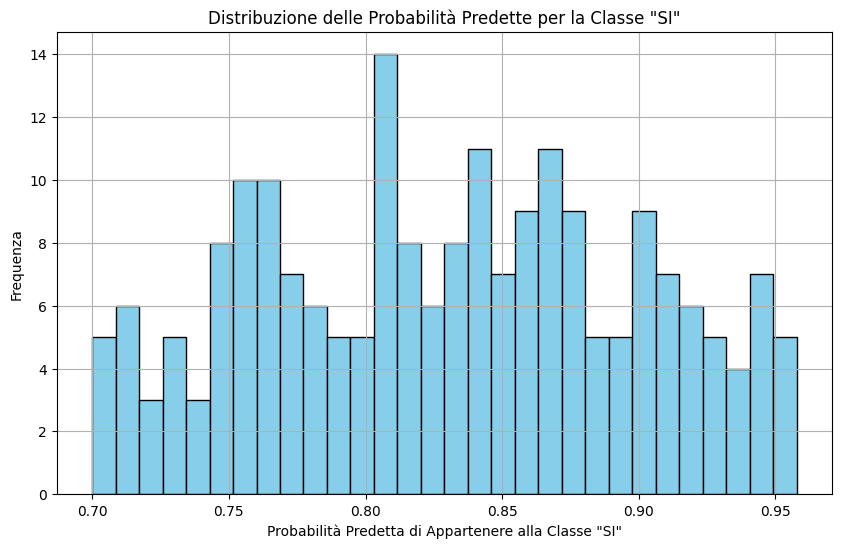

In [67]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

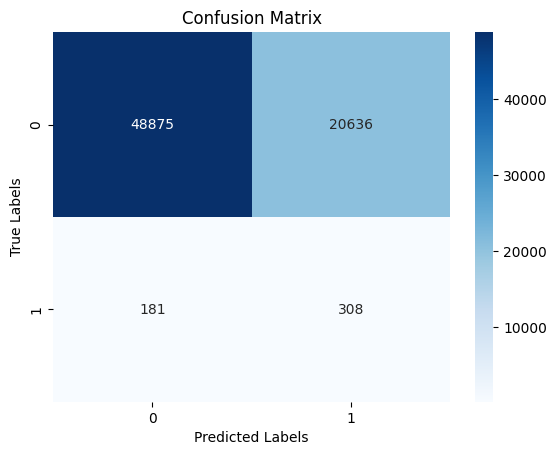

In [68]:
xgb_predictions_synt = best_xgb_classifier.predict(X_train_res_synthetic)
lgbm_predictions_synt = best_lgb_classifier.predict(X_train_res_synthetic)
catboost_predictions_synt = best_catboost_classifier.predict(X_train_res_synthetic)
ensemble_predictions_synth = (weight_catboost * catboost_predictions_synt) + (weight_xgb* xgb_predictions_synt) + (weight_lgbm * lgbm_predictions_synt)

y_pred_binary = np.where(ensemble_predictions_synth > 0.5, 1, 0)

cm = confusion_matrix(y_synthetic, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Test Dataset

In [21]:
competition_df = pd.read_csv(r"Dataset/Churn_clean_competition.csv")


In [22]:
competition_df['Professione'] = competition_df['Professione'].apply(lambda x: 'Ufficiale/Sottoufficiale' if x == 'Ufficiale/Sottufficiale' else 
                                                                  'Libero professionista/Titolare impresa' if x == 'Libero professionista/Titolare di impresa' else 
                                                                  x)
competition_df['Provincia_Residenza'] = competition_df['Provincia_Residenza'].replace('FO', 'FC')
competition_df['Provincia_Domicilio'] = competition_df['Provincia_Domicilio'].replace('FO', 'FC')

competition_df['Provincia_Residenza'] = competition_df['Provincia_Residenza'].replace('PS', 'PU')
competition_df['Provincia_Domicilio'] = competition_df['Provincia_Domicilio'].replace('PS', 'PU')

competition_df['Provincia_Domicilio'] = competition_df['Provincia_Domicilio'].replace('8N', np.nan)
competition_df['Provincia_Domicilio'] = competition_df['Provincia_Domicilio'].replace('BE', np.nan)
mapping = {
    'CAUTO': 1,
    'PRUDENTE': 2,
    'BILANCIATO': 3,
    'DINAMICO':4,
    'ND':0
}
competition_df['Profilo_MIFID'] = competition_df['Profilo_MIFID'].replace(mapping)

mapping2 = {
    'Bassissimo (<1200)': 1,
    'Basso (tra 1200 e 1500)': 2,
    'Medio (tra 1500 e 1800)': 3,
    'Alto (tra 1800 e 2500)':4,
    'Altissimo (>2500)':5
}

competition_df['Imp_Reddito'] = competition_df['Imp_Reddito'].replace(mapping2)


In [23]:
competition_df = pd.get_dummies(competition_df)
competition_df = clean_feature_names(competition_df)

missing_columns_train = set(XX.columns) - set(competition_df.columns)
for col in missing_columns_train:
    competition_df[col] = 0  

competition_df = competition_df[XX.columns]

print("Training features:", competition_df.shape)


Training features: (177783, 276)


In [24]:
# Rinomina le colonne per corrispondere esattamente a quelle utilizzate nell'addestramento
competition_df.columns = [col.replace(' ', '_') for col in competition_df.columns]

xgb_predictions_synt = best_xgb_classifier.predict_proba(competition_df)[:, 1]
lgbm_predictions_synt = best_lgb_classifier.predict_proba(competition_df)[:, 1]
catboost_predictions_synt = best_catboost_classifier.predict_proba(competition_df)[:, 1]
ensemble_predictions_comp = (weight_catboost * catboost_predictions_synt) + (weight_xgb* xgb_predictions_synt) + (weight_lgbm * lgbm_predictions_synt)


In [25]:
ensemble_predictions_comp

array([0.15998903, 0.26816252, 0.41631391, ..., 0.6130494 , 0.13024283,
       0.19772672])

In [26]:
results_df = pd.DataFrame({
    'y_pred_proba': ensemble_predictions_comp

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si_comp = results_df_si_sorted.head(10000)
print(top_10000_si_comp)

        y_pred_proba
1457        0.988086
24143       0.987947
4561        0.987081
39130       0.987014
48227       0.987000
...              ...
38292       0.857392
50790       0.857381
63410       0.857380
135763      0.857375
41933       0.857374

[10000 rows x 1 columns]


In [27]:
df = pd.read_csv(r"Dataset/Churn_Banking_Deployment.csv", encoding='ISO-8859-1')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177783 entries, 0 to 177782
Data columns (total 42 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Id_Cliente                           177783 non-null  int64  
 1   Imp_Valore_del_Cliente               177781 non-null  float64
 2   Flag_Apertura_Conto_Online           177783 non-null  int64  
 3   Flag_Possesso_piu_Conti              177783 non-null  int64  
 4   Eta                                  177782 non-null  float64
 5   Provincia_Domicilio                  167658 non-null  object 
 6   Provincia_Residenza                  168460 non-null  object 
 7   Anno_Apertura_primo_Conto            177783 non-null  float64
 8   Professione                          160796 non-null  object 
 9   Imp_Reddito                          73812 non-null   object 
 10  Tipologia_Cliente                    177781 non-null  object 
 11  Sesso        

In [28]:
df['y_pred_proba'] = ensemble_predictions_comp

# Sort the dataframe by prediction probabilities in descending order
sorted_df = df.sort_values(by='y_pred_proba', ascending=False)

# Select the top 10,000 entries
top_10000_si_comp = sorted_df.head(10000)

# Save the top 10,000 entries to an Excel file
output_file_path = 'Top_10000_SI_Competittion.xlsx'
top_10000_si_comp.to_excel(output_file_path, index=False, engine='openpyxl')
